# Analytical approach

We start off by getting the libraries for our jupyter notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import egttools as egt

## Default parameter values
Here we define the default parameter values for the prisoner's dilemma and the snowdrift game.

Reward table for the prisoner's dilemma:

| PD | C | D  |
|----|---|----|
| C  | 1 | -1 |
| D  | 2 | 0  |

Reward table for the snowdrift game:

| SD | C | D  |
|----|---|----|
| C  | 1 | 0  |
| D  | 2 | -1 |

In [2]:
# Parameters for the pay-off matrix
## The reward values (prisoner's dilemma)
R_pd = 1
S_pd = -1
T_pd = 2
P_pd = 0
## The reward values (snowdrift)
R_sd = 1
S_sd = 0
T_sd = 2
P_sd = -1
## The values used to calculate the reward for a certain strategy
gamma = 1 # Importance of the game
r = 50 # number of rounds
theta = 3 # trust threshold
p = 0.25 # Chance of checking
epsilon = 0.25 # opportunity cost
# Parameters for the game settings
beta = 0.1 # intensity of selection
Z = 100 # Population size (N)
mu = 0 # the mutation probability
nb_strategies_with = 5 # The amount of strategies
strategies = ["ALLC","ALLD","TFT","TUC","TUD"] # The name of each strategy
colors_strat = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple"] # the color for each strategy
nb_strategies_without = 3 # the amount of strategies without TUC and TUD
colors_trust = ["tab:orange","tab:blue"] # The color for the frequency of trust
# boolean to run smaller experiments seperatly
run_small = True
run_big = True

## Function for calculating our pay-off matrix
Here we define a function that can calculate the pay-off matrix with our parameters:
- $R,S,T,P$ (the values of the game)
- $\gamma$ (the importance of a game)
- $r$ (the amount of rounds)
- $\theta$ (the trust threshold)
- $p$ (the chance of checking)
- $\epsilon$ (the opportunity cost of checking)

In [3]:
def calculate_pay_off(R,S,T,P,gamma,r,theta,p,epsilon):
    # Multiply the rewards with the importance of the game
    R *= gamma
    S *= gamma
    T *= gamma
    P *= gamma
    # Calculate the value of each strategy
    # static table
    ## Always cooperate (ALLC)
    ALLC_ALLC = R
    ALLC_ALLD = S
    ALLC_TFT = R
    ALLC_TUC = R
    ALLC_TUD = (theta*R+(r-theta)*S)/r
    ALLC = [ALLC_ALLC,ALLC_ALLD,ALLC_TFT,ALLC_TUC,ALLC_TUD]
    ## Always defect (ALLD)
    ALLD_ALLC = T
    ALLD_ALLD = P
    ALLD_TFT = (T+(r-1)*P)/r
    ALLD_TUC = (T+(r-1)*P)/r
    ALLD_TUD = (T+(r-1)*P)/r
    ALLD = [ALLD_ALLC,ALLD_ALLD,ALLD_TFT,ALLD_TUC,ALLD_TUD]
    ## Tit for Tat (TFT)
    TFT_ALLC = R-epsilon
    TFT_ALLD = (S+(r-1)*P)/r - epsilon
    TFT_TFT = R - epsilon
    TFT_TUD = R - epsilon
    TFT_TUC = (theta*R+S+(r-theta-1)*P)/r - epsilon
    TFT = [TFT_ALLC,TFT_ALLD,TFT_TFT,TFT_TUD,TFT_TUC]
    ## Trust-based Cooperate (TUC)
    TUC_ALLC = R - (theta*epsilon)/r - (p*(r-theta)*epsilon)/r
    TUC_ALLD = (S + (r-1)*P)/r - epsilon
    TUC_TFT = R-(theta*epsilon)/r-(p*(r-theta)*epsilon)/r
    TUC_TUC = R-(theta*epsilon)/r-(p*(r-theta)*epsilon)/r
    TUC_TUD = (theta*R-theta*epsilon)/r + (1/r)*((S*(1-(1-p)**(r-theta)))/p + ((P-epsilon)*((1-p)**(r-theta)+(r-theta)*p - 1))/p)
    TUC = [TUC_ALLC,TUC_ALLD,TUC_TFT,TUC_TUC,TUC_TUD]
    ## Trust-based Defect (TUD)
    TUD_ALLC = (epsilon*R+(r-epsilon)*T-theta*epsilon)/r
    TUD_ALLD = (S+(r-1)*P)/r-epsilon
    TUD_TFT = (theta*R+T+(r-theta-1)*P-theta*epsilon)/r
    TUD_TUC = (theta*R-theta*epsilon)/r + (1/r)*((T*(1 - (1 - p) ** (r - theta)))/p + (P*((1-p)**(r-theta) + (r - theta)*p - 1))/p)
    TUD_TUD = (theta*R+(r - theta) * P - theta*epsilon)/r
    TUD = [TUD_ALLC,TUD_ALLD,TUD_TFT,TUD_TUC,TUD_TUD]
    # Return the values as an array
    return np.array([
        ALLC,
        ALLD,
        TFT,
        TUC,
        TUD,])

## run for default parameters
We start of by running the experiments for the default parameters and returning the distribution in both text and using a barplot.
### Prisoner's Dilemma
Here we calculate the stationary distribution for the prisoner's dilemma.

In [4]:
# Calculate the pay-off matrix
pay_off_pd = calculate_pay_off(R_pd,S_pd,T_pd,P_pd,gamma,r,theta,p,epsilon)
# Create an evolver
evolver_pd = egt.analytical.StochDynamics(nb_strategies_with, pay_off_pd, Z, mu)
# Calculate the stationary distribution
stationary_SML_pd = evolver_pd.calculate_stationary_distribution(beta)

In [5]:
# Print out the value for each strategy
print("time spent as Always Cooperate: {} & time spent as Always Cheat: {} & time spent as Tit for Tat: {} & time spent as Trust-based Cooperate {} & time spent as Trust-based Defect {}".format(*stationary_SML_pd))

time spent as Always Cooperate: 0.04444423948049365 & time spent as Always Cheat: 0.2653608065886105 & time spent as Tit for Tat: 0.12223515328999357 & time spent as Trust-based Cooperate 0.3995190913542364 & time spent as Trust-based Defect 0.16844070928666582


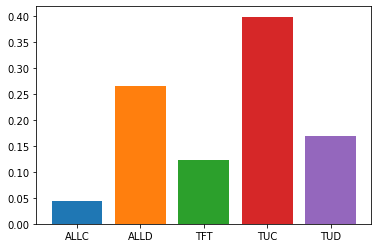

In [6]:
# Create the bar chart for each of the strategies
fig_pd,ax_pd = plt.subplots()
ax_pd.bar(strategies,[*stationary_SML_pd],color = colors_strat)
fig_pd.savefig(f'prisoner/default.png')

In [7]:
# Close the figure to conserve memory
plt.close(fig_pd)

### Snowdrift
Here we calculate the stationary distribution for the snowdrift game.

In [8]:
# Calculate the pay-off matrix
pay_off_sd = calculate_pay_off(R_sd,S_sd,T_sd,P_sd,gamma,r,theta,p,epsilon)
# Create the evolver
evolver_sd = egt.analytical.StochDynamics(nb_strategies_with, pay_off_sd, Z, mu)
# Calculte the stationary distribution
stationary_SML_sd = evolver_sd.calculate_stationary_distribution(beta)

In [9]:
# Print out the value for each strategy
print("time spent as Always Cooperate: {} & time spent as Always Cheat: {} & time spent as Tit for Tat: {} & time spent as Trust-based Cooperate {} & time spent as Trust-based Defect {}".format(*stationary_SML_sd))

time spent as Always Cooperate: 0.18208775957580695 & time spent as Always Cheat: 0.10520550751886781 & time spent as Tit for Tat: 0.13278599398354254 & time spent as Trust-based Cooperate 0.4869466439199093 & time spent as Trust-based Defect 0.09297409500187344


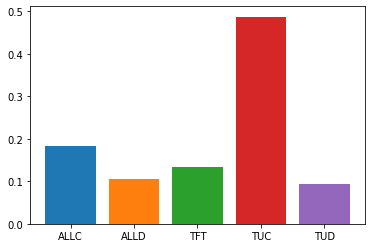

In [10]:
# Create the bar chart for each of the strategies
fig_sd,ax_sd = plt.subplots()
ax_sd.bar(strategies,[*stationary_SML_sd],color = colors_strat)
fig_pd.savefig(f'snowdrift/default.png')

In [11]:
# Close the figure to conserve memory
plt.close(fig_sd)

## Experiments
There is a total of 4 experiments where the 4th experiments uses the first 3.
The smaller experiments are:
- First the influence of $\epsilon$ on the stationary distribution is measured
- Than the influence of $\gamma$ and $r$ is measured
- Lastly the influece of $p$ and $\epsilon$ is measured

The 3 previous experiments are repeated for different values of $\theta$

### Influence of $\epsilon$
The first experiment is to variate the value of epsilon and return the distrubtion for each of these values.

In [12]:
# The function for testing different epsilon values
def test_epsilons(R,S,T,P,gamma,r,theta,p,nb_strategies_with,strategies,nb_strategies_without,beta,Z,mu,epsilons):
    # for the frequencies of strategies
    results = np.zeros((nb_strategies_with,len(epsilons)))
    # for the frequency of cooperation
    results_without = np.zeros((nb_strategies_without,len(epsilons)))
    for pos in range(len(epsilons)):
        # get the epsilon
        epsilon = epsilons[pos]
        # calculate the pay-offs
        pay_off = calculate_pay_off(R,S,T,P,gamma,r,theta,p,epsilon)
        # for all the strategies
        evolver = egt.analytical.StochDynamics(nb_strategies_with,pay_off,Z,mu)
        # calculate the stationary distribution
        stationary_SML = evolver.calculate_stationary_distribution(beta)
        # add the percentage of each strategy and epsilon to the results
        for strategy,v in zip(range(nb_strategies_with),stationary_SML):
            results[strategy][pos] = v
        # for all strategies except TUC and TUD
        evolver = egt.analytical.StochDynamics(nb_strategies_without, pay_off, Z,mu)
        # calculate the stationary distribution
        stationary_SML = evolver.calculate_stationary_distribution(beta)
        # add the percentage of each strategy and epsilon to the results
        for strategy,v in zip(range(nb_strategies_without),stationary_SML):
            results_without[strategy][pos] = v
    without_trust = np.array([results_without[0][pos] + results_without[2][pos] for pos in range(len(epsilons))])
    with_trust = np.array([results[0][pos] + results[2][pos] + results[3][pos] + (results[4][pos] * (theta/r)) for pos in range(len(epsilons))])
    return results,without_trust,with_trust

# The function for visualising the returns of the epsilon values
def visualise_epsilons(ax_strat,ax_coop,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,epsilons,result,without_trust,with_trust):
    # for the frequencies of strategies
    # Plot the line for each of the strategies
    for pos,color_strat in zip(range(nb_strategies_with),colors_strat):
        ax_strat.plot(epsilons,result[pos],label = strategies[pos],color = color_strat)
    # Enable the legend of the graph
    ax_strat.legend()
    # Set the limits and labels of the X and Y axis
    ax_strat.set_xlabel("Opportunity cost $\epsilon$")
    ax_strat.set_ylabel("Frequency of Strategy")
    ax_strat.set_xlim(0,1)
    ax_strat.set_ylim(0,1)
    # for the frequency of cooperation
    # Get the values of all the strategies that like to cooperate (without trust)
    
    ax_coop.plot(epsilons,without_trust,label = "without TUC/TUD",color = colors_trust[0])
    # Get the values of all the strategies that like to cooperate (with trust)
    ax_coop.plot(epsilons,with_trust,label = "with TUC/TUD",color = colors_trust[1])
    # Color the area between the two plots in green when the with_trust is above and red when the without_trust is above
    ax_coop.fill_between(epsilons, with_trust, without_trust, where=(with_trust > without_trust), color='green', alpha=0.3)
    ax_coop.fill_between(epsilons, with_trust, without_trust, where=(with_trust < without_trust), color='red', alpha=0.3)
    # Enable the legend of the graph
    ax_coop.legend()
    # Set the limits and labels of the X and Y axis
    ax_coop.set_xlim(0,1)
    ax_coop.set_ylim(0,1)
    ax_coop.set_xlabel("Opportunity cost $\epsilon$")
    ax_coop.set_ylabel("Frequency of Cooperation")

### The experiment for $\epsilon$

In [13]:
# all epsilons we want to test
epsilons = np.arange(0,1.01,0.01)

#### Prisoner's dilemma

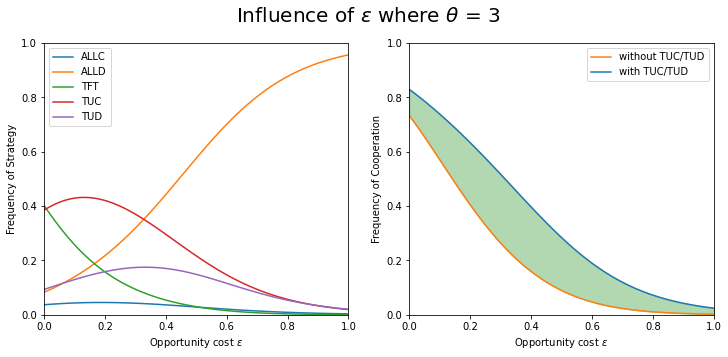

In [14]:
if run_small:
    # Run the acual experiment
    epsilons_strat,epsilons_without,epsilons_with = test_epsilons(R_pd,S_pd,T_pd,P_pd,gamma,r,theta,p,nb_strategies_with,strategies,nb_strategies_without,beta,Z,mu,epsilons)
    # create the subplots for the visualisation
    fig_epsilon,(ax_strat_epsilon,ax_coop_epsilon) = plt.subplots(1,2,figsize=(12,5))
    # add the title to the plots
    fig_epsilon.suptitle("Influence of $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size = 20)
    # visualise the results on the subplots
    visualise_epsilons(ax_strat_epsilon,ax_coop_epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,epsilons,epsilons_strat,epsilons_without,epsilons_with)
    # save the figure
    fig_epsilon.savefig(f'figure/epsilon_theta_{theta}_pd.png')

In [15]:
if run_small:
    # close the plot of the figure of epsilon
    plt.close(fig_epsilon)

### Snowdrift game

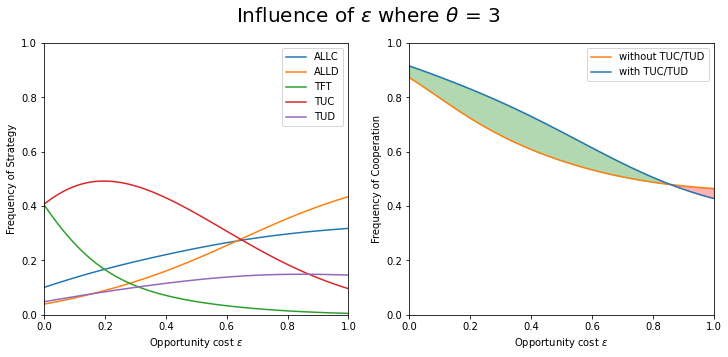

In [16]:
if run_small:
    # Calculate the epsilon values
    epsilons_strat,epsilons_without,epsilons_with = test_epsilons(R_sd,S_sd,T_sd,P_sd,gamma,r,theta,p,nb_strategies_with,strategies,nb_strategies_without,beta,Z,mu,epsilons)
    # create the subplots for the visualisation
    fig_epsilon,(ax_strat_epsilon,ax_coop_epsilon) = plt.subplots(1,2,figsize=(12,5))
    # add the title to the plots
    fig_epsilon.suptitle("Influence of $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size = 20)
    # visualise the results on the subplots
    visualise_epsilons(ax_strat_epsilon,ax_coop_epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,epsilons,epsilons_strat,epsilons_without,epsilons_with)
    # save the figure
    fig_epsilon.savefig(f'figure/epsilon_theta_{theta}_sd.png')

In [17]:
if run_small:
    # close the plot of the figure of epsilon
    plt.close(fig_epsilon)

## Influence of $\gamma$ and r
The second experiment tests the influence of $\gamma$ and $r$ on the stationary distribution

In [18]:
# The function for testing the influence of gamma and r
def test_gamma_r(R,S,T,P,theta,p,epsilon,nb_strategies_with,nb_strategies_without,beta,Z,mu,gammas,rs):
    # array for the results with the trust-strategies and without the trust-strategies
    results = []
    results_without_r = []
    results_with_r = []
    # go over every r in the rs
    for r in rs:
        # for the frequencies of strategies
        results_with = np.zeros((nb_strategies_with,len(gammas)))
        # for the frequency of cooperation
        results_without = np.zeros((nb_strategies_without,len(gammas)))
        # go over all the gammas
        for pos in range(len(gammas)):
            # get the gamma
            gamma = gammas[pos]
            # calculate the pay-offs
            pay_off = calculate_pay_off(R,S,T,P,gamma,r,theta,p,epsilon)
            # for all strategies
            evolver = egt.analytical.StochDynamics(nb_strategies_with,pay_off,Z,mu)
            # calculate the stationary distribution
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            # store the results
            for strategy,v in zip(range(nb_strategies_with),stationary_SML):
                results_with[strategy][pos] = v
            # for all strategies except TUC and TUD
            evolver = egt.analytical.StochDynamics(nb_strategies_without, pay_off, Z,mu)
            # calculate the stationary distribution
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            # safe the result
            for strategy,v in zip(range(nb_strategies_without),stationary_SML):
                results_without[strategy][pos] = v
        # append the results to the global result collection
        results.append(results_with)
        results_without_r.append(np.array([results_without[0][pos] + results_without[2][pos] for pos in range(len(gammas))]))
        results_with_r.append(np.array([results_with[0][pos] + results_with[2][pos] + results_with[3][pos] + (results_with[4][pos] * (theta/r)) for pos in range(len(gammas))]))
    return results,results_without_r,results_with_r

# This function visualises the results
def visualise_gamma_r(ax_strats,ax_coops,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,gammas,rs,results,results_without_trust,results_with_trust):
    for r,ax_strat,ax_coop,result,without_trust,with_trust in zip(rs,ax_strats,ax_coops,results,results_without_trust,results_with_trust):
        # for the frequencies of strategies
        # Plot the line for each of the strategies
        for pos,color_strat in zip(range(nb_strategies_with),colors_strat):
            ax_strat.plot(gammas,result[pos],label = strategies[pos],color = color_strat)
        # enable the legend for the graph
        ax_strat.legend()
        # give the x and y axis a label
        ax_strat.set_xlabel("importance of the game $\gamma$")
        ax_strat.set_ylabel("Frequency of Strategy")
        # put the x axis to a exponential scale
        ax_strat.set_xscale("symlog")
        # limit the x and y axis
        ax_strat.set_xlim(0.1,1000)
        ax_strat.set_ylim(0,1)
        # for the frequency of cooperation
        # Get the values of all the strategies that like to cooperate (without trust)
        ax_coop.plot(gammas,without_trust,label = "without TUC/TUD",color = colors_trust[0])
        # Get the values of all the strategies that like to cooperate (with trust)
        ax_coop.plot(gammas,with_trust,label = "with TUC/TUD",color = colors_trust[1])
        # color the gaps in between
        ax_coop.fill_between(gammas, with_trust, without_trust, where=(with_trust > without_trust), color='green', alpha=0.3)
        ax_coop.fill_between(gammas, with_trust, without_trust, where=(with_trust < without_trust), color='red', alpha=0.3)
        # enable the legend
        ax_coop.legend()
        # give the x and y axis a label
        ax_coop.set_xlabel("importance of the game $\gamma$")
        ax_coop.set_ylabel("Frequency of Cooperation")
        # put the x axis to an exponential scale
        ax_coop.set_xscale("symlog")
        # limit the x and y axis
        ax_coop.set_xlim(0.1,1000)
        ax_coop.set_ylim(0,1)
        # add titles
        ax_strat.set_title(f"r = {r}",size = 15)

### The experiment for $\gamma$ and r

In [19]:
# all the gammas and rs we want to test
gammas = np.geomspace(0.1,1000,100)
rs = np.array([20,50,100])

#### Prisoner's dilemma

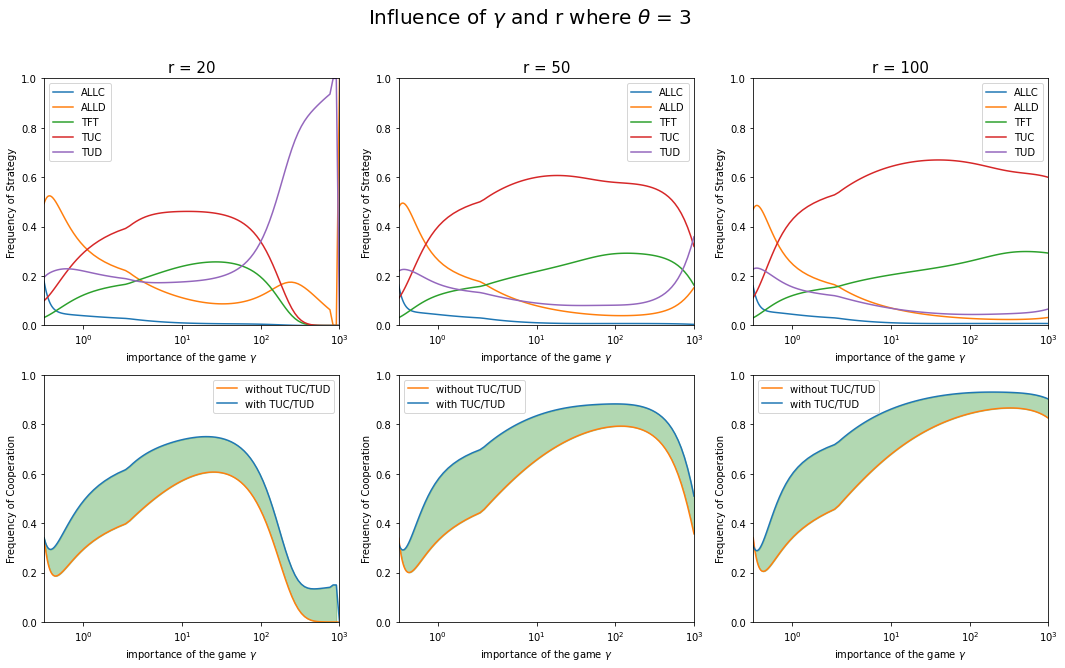

In [20]:
if run_small:
    # run the actual experiment
    gammas_result,gammas_without_r,gammas_with_r = test_gamma_r(R_pd,S_pd,T_pd,P_pd,theta,p,epsilon,nb_strategies_with,nb_strategies_without,beta,Z,mu,gammas,rs)
    # create a subplot for the results
    fig_gamma,(ax_strats_gamma,ax_coops_gamma) = plt.subplots(2,3,figsize=(18,10))
    # add a title
    fig_gamma.suptitle("Influence of $\gamma$ and r where " + r"$\theta$ = " + f"{theta}",size=20)
    # visualise the results
    visualise_gamma_r(ax_strats_gamma,ax_coops_gamma,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,gammas,rs,gammas_result,gammas_without_r,gammas_with_r)
    # save a figure of the results
    fig_gamma.savefig(f'figure/gamma_and_r_theta_{theta}_pd.png')

In [21]:
if run_small:
    # close the plot
    plt.close(fig_gamma)

#### Snowdrift game

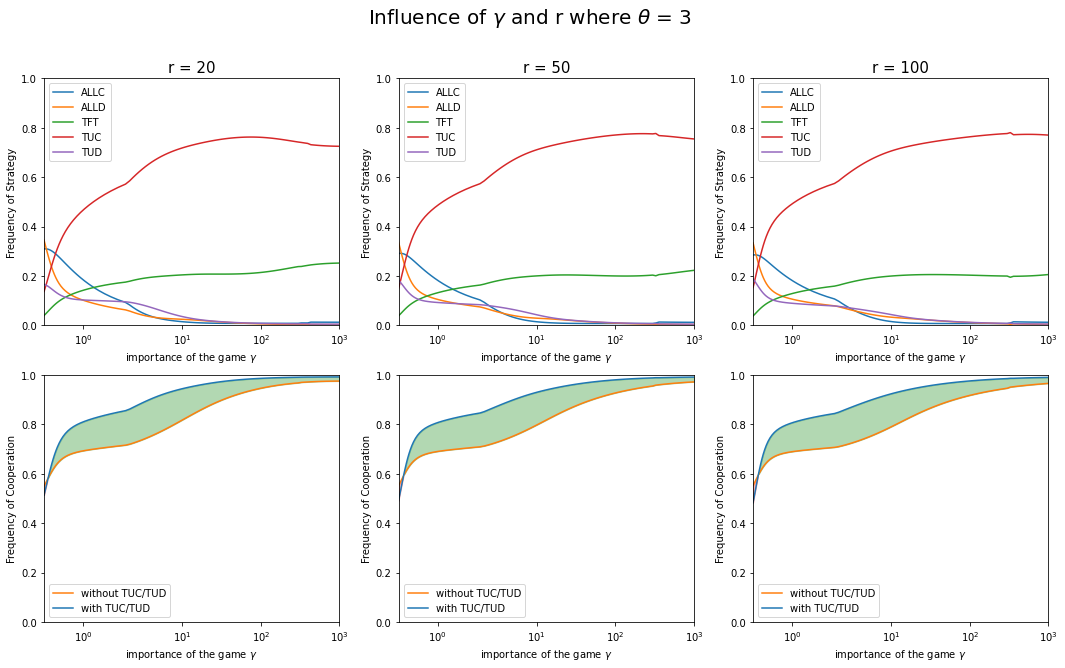

In [22]:
if run_small:
    # run the actual experiment
    gammas_result,gammas_without_r,gammas_with_r = test_gamma_r(R_sd,S_sd,T_sd,P_sd,theta,p,epsilon,nb_strategies_with,nb_strategies_without,beta,Z,mu,gammas,rs)
    # create a subplot for the results
    fig_gamma,(ax_strats_gamma,ax_coops_gamma) = plt.subplots(2,3,figsize=(18,10))
    # add a title
    fig_gamma.suptitle("Influence of $\gamma$ and r where " + r"$\theta$ = " + f"{theta}",size=20)
    # visualise the results
    visualise_gamma_r(ax_strats_gamma,ax_coops_gamma,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,gammas,rs,gammas_result,gammas_without_r,gammas_with_r)
    # save a figure of the results
    fig_gamma.savefig(f'figure/gamma_and_r_theta_{theta}_sd.png')

In [23]:
if run_small:
    # close the plot
    plt.close(fig_gamma)

## Influence of p and $\epsilon$
The third experiment tests the influence of $p$ and $\epsilon$ on the stationary distribution

In [24]:
def test_p_epsilon(R,S,T,P,gamma,r,theta,nb_strategies_with,nb_strategies_without,beta,Z,mu,ps,epsilons):
    # array for the results with the trust-strategies and without the trust-strategies
    results = []
    results_without_epsilon = []
    results_with_epsilon = []
    # go over each epsilon
    for epsilon in epsilons:
        # for the frequencies of strategies
        results_with = np.zeros((nb_strategies_with,len(ps)))
        # for the frequency of cooperation
        results_without = np.zeros((nb_strategies_without,len(ps)))
        for pos in range(len(ps)):
            # for all strategies
            # get the p value 
            p = 1/ps[pos]
            # calculate the pay-off matrix
            pay_off = calculate_pay_off(R,S,T,P,gamma,r,theta,p,epsilon)
            # create the evolver
            evolver = egt.analytical.StochDynamics(nb_strategies_with,pay_off,Z,mu)
            # calculate the stationary distribution
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            # store the results
            for strategy,v in zip(range(nb_strategies_with),stationary_SML):
                results_with[strategy][pos] = v
            # for all strategies except TUC and TUD
            # create the evolver
            evolver = egt.analytical.StochDynamics(nb_strategies_without, pay_off, Z,mu)
            # calculate the stationary disribution
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            # store the results
            for strategy,v in zip(range(nb_strategies_without),stationary_SML):
                results_without[strategy][pos] = v
        # store the intermediate results
        results.append(results_with)
        results_without_epsilon.append(np.array([results_without[0][pos] + results_without[2][pos] for pos in range(len(ps))]))
        results_with_epsilon.append(np.array([results_with[0][pos] + results_with[2][pos] + results_with[3][pos] + (results_with[3][pos] * (theta/r)) for pos in range(len(ps))]))
    return results,results_without_epsilon,results_with_epsilon

# visualises the results
def visualise_p_epsilon(ax_strats,ax_coops,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,ps,epsilons,results,results_without_trust,results_with_trust):
    for epsilon,ax_strat,ax_coop,result,without_trust,with_trust in zip(epsilons,ax_strats,ax_coops,results,results_without_trust,results_with_trust):
        # for the frequencies of strategies
        # Plot the line for each of the strategies
        for pos,color_strat in zip(range(nb_strategies_with),colors_strat):
            ax_strat.plot(ps,result[pos],label = strategies[pos],color = color_strat)
        # enable the legend
        ax_strat.legend()
        # add a label to the axis
        ax_strat.set_xlabel("trustfulness $1/p$")
        ax_strat.set_ylabel("Frequency of Strategy")
        # limit the axis
        ax_strat.set_xlim(0,100)
        ax_strat.set_ylim(0,1)
        # for the frequency of cooperation
        # Get the values of all the strategies that like to cooperate (without trust)
        ax_coop.plot(ps,without_trust,label = "without TUC/TUD",color = colors_trust[0])
        # Get the values of all the strategies that like to cooperate (with trust)
        ax_coop.plot(ps,with_trust,label = "with TUC/TUD",color = colors_trust[1])
        # fill the gap between the two lines
        ax_coop.fill_between(ps, with_trust, without_trust, where=(with_trust > without_trust), color='green', alpha=0.3)
        ax_coop.fill_between(ps, with_trust, without_trust, where=(with_trust < without_trust), color='red', alpha=0.3)
        # enable the legend
        ax_coop.legend()
        # add labels to the axis
        ax_coop.set_xlabel("trustfulness $1/p$")
        ax_coop.set_ylabel("Frequency of Cooperation")
        # limit the axis
        ax_coop.set_xlim(0,100)
        ax_coop.set_ylim(0,1)
        # add titles
        ax_strat.set_title(f"epsilon = {epsilon}",size = 15)

### the experiment for p and $\epsilon$

In [25]:
# all the ps and epsilons we like to test
ps = np.arange(1,101,1)
epsilons = np.array([0,0.2,0.5])

#### Prisoner's dillema

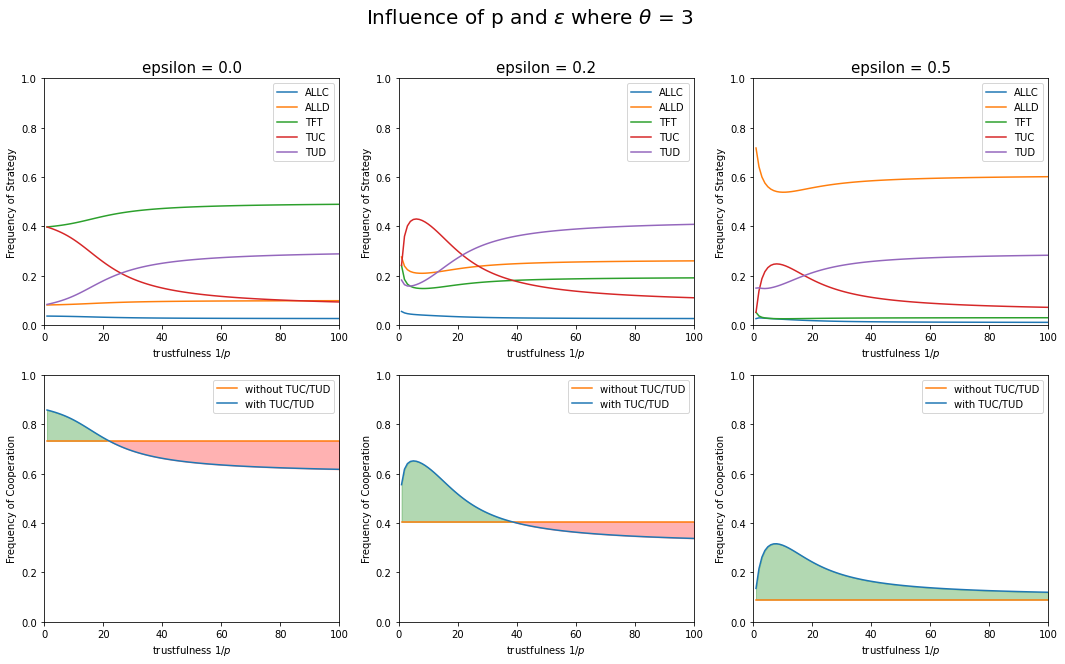

In [26]:
if run_small:
    # do the actual experiment
    ps_results,ps_without,ps_with = test_p_epsilon(R_pd,S_pd,T_pd,P_pd,gamma,r,theta,nb_strategies_with,nb_strategies_without,beta,Z,mu,ps,epsilons)
    # create a subplot
    fig_p,(ax_strats_p,ax_coops_p) = plt.subplots(2,3,figsize=(18,10))
    # add a title
    fig_p.suptitle("Influence of p and $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size=20)
    # visualise the results
    visualise_p_epsilon(ax_strats_p,ax_coops_p,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,ps,epsilons,ps_results,ps_without,ps_with)
    # save the figure
    fig_p.savefig(f'figure/p_and_epsilon_theta_{theta}_pd.png')

In [27]:
if run_small:
    # close the plot to save memory
    plt.close(fig_p)

#### snowdrift game

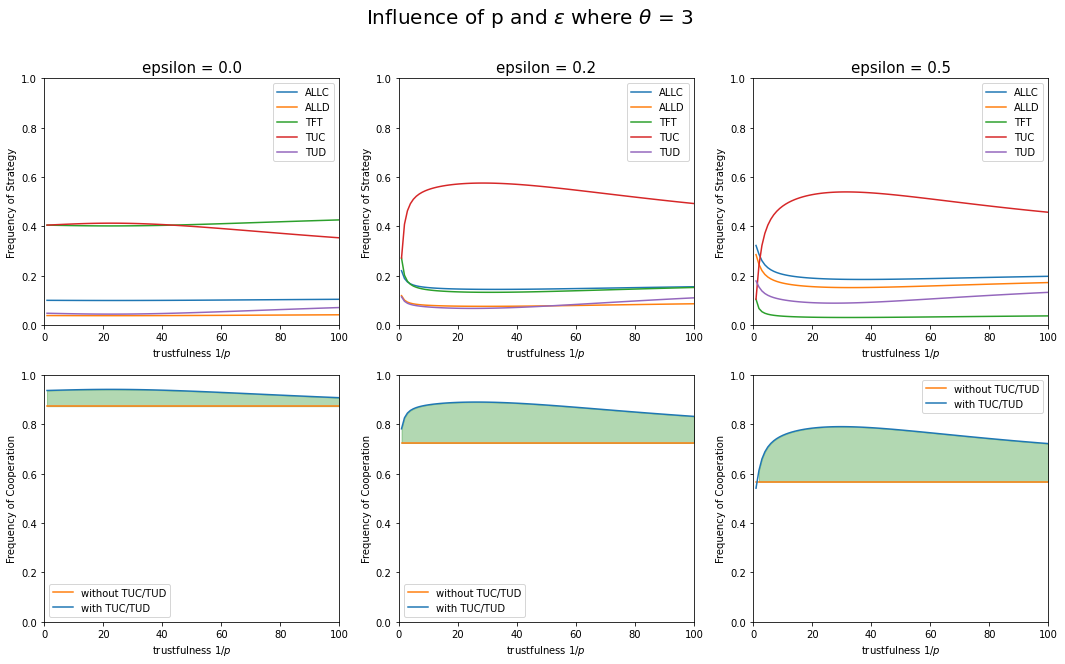

In [28]:
if run_small:
    # do the actual experiment
    ps_results,ps_without,ps_with = test_p_epsilon(R_sd,S_sd,T_sd,P_sd,gamma,r,theta,nb_strategies_with,nb_strategies_without,beta,Z,mu,ps,epsilons)
    # create a subplot
    fig_p,(ax_strats_p,ax_coops_p) = plt.subplots(2,3,figsize=(18,10))
    # add a title
    fig_p.suptitle("Influence of p and $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size=20)
    # visualise the results
    visualise_p_epsilon(ax_strats_p,ax_coops_p,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,ps,epsilons,ps_results,ps_without,ps_with)
    # save the figure
    fig_p.savefig(f'figure/p_and_epsilon_theta_{theta}_sd.png')

In [29]:
if run_small:
    # close the plot to save memory
    plt.close(fig_p)

## Do the previous experiments for different $\theta$

In [30]:
def test_and_visualise_theta(R,S,T,P,gamma,r,p,epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,beta,Z,mu,thetas,epsilons,gammas,rs,ps,epsilons_ps,path):
    figures = []
    for theta in thetas:
        ### epsilons
        # run the actual experiment
        epsilons_strat,epsilons_without,epsilons_with = test_epsilons(R,S,T,P,gamma,r,theta,p,nb_strategies_with,strategies,nb_strategies_without,beta,Z,mu,epsilons)
        # create the subplots for the visualisation
        fig_epsilon,(ax_strat_epsilon,ax_coop_epsilon) = plt.subplots(1,2,figsize=(12,5))
        # add the title to the plots
        fig_epsilon.suptitle("Influence of $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size = 20)
        # visualise the results on the subplots
        visualise_epsilons(ax_strat_epsilon,ax_coop_epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,epsilons,epsilons_strat,epsilons_without,epsilons_with)
        # save the figure
        fig_epsilon.savefig(f'{path}/epsilon_theta_{theta}.png')
        ### gamma and r
        # run the actual experiment
        gammas_result,gammas_without_r,gammas_with_r = test_gamma_r(R,S,T,P,theta,p,epsilon,nb_strategies_with,nb_strategies_without,beta,Z,mu,gammas,rs)
        # create a subplot for the results
        fig_gamma,(ax_strats_gamma,ax_coops_gamma) = plt.subplots(2,3,figsize=(18,10))
        # add a title
        fig_gamma.suptitle("Influence of $\gamma$ and r where " + r"$\theta$ = " + f"{theta}",size=20)
        # visualise the results
        visualise_gamma_r(ax_strats_gamma,ax_coops_gamma,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,gammas,rs,gammas_result,gammas_without_r,gammas_with_r)
        # save the figure
        fig_gamma.savefig(f'{path}/gamma_theta_{theta}.png')
        ### p and epsilon
        # run the actual experiment
        # do the actual experiment
        ps_results,ps_without,ps_with = test_p_epsilon(R,S,T,P,gamma,r,theta,nb_strategies_with,nb_strategies_without,beta,Z,mu,ps,epsilons_ps)
        # create a subplot
        fig_p,(ax_strats_p,ax_coops_p) = plt.subplots(2,3,figsize=(18,10))
        # add a title
        fig_p.suptitle("Influence of p and $\epsilon$ where " + r"$\theta$ = " + f"{theta}",size=20)
        # visualise the results
        visualise_p_epsilon(ax_strats_p,ax_coops_p,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,ps,epsilons_ps,ps_results,ps_without,ps_with)
        # safe the figure
        fig_p.savefig(f'{path}/p_and_epsilon_theta_{theta}.png')
        # add the figures  to a list to close them later
        figures.append(fig_epsilon)
        figures.append(fig_gamma)
        figures.append(fig_p)
    return figures

### The experiment for $\theta$

In [31]:
# the parameters we want to test
thetas = [3,5,10]
epsilons = np.arange(0,1.01,0.01)
gammas = np.geomspace(0.1,1000,100)
rs = np.array([20,50,100])
ps = np.arange(1,101,1)
epsilons_ps = np.array([0,0.2,0.5])

#### Prisoner's dilemma

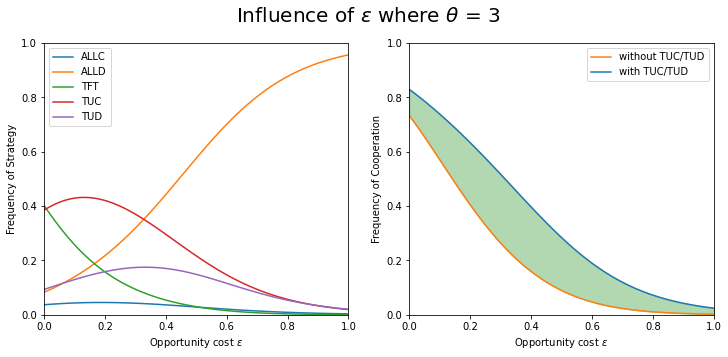

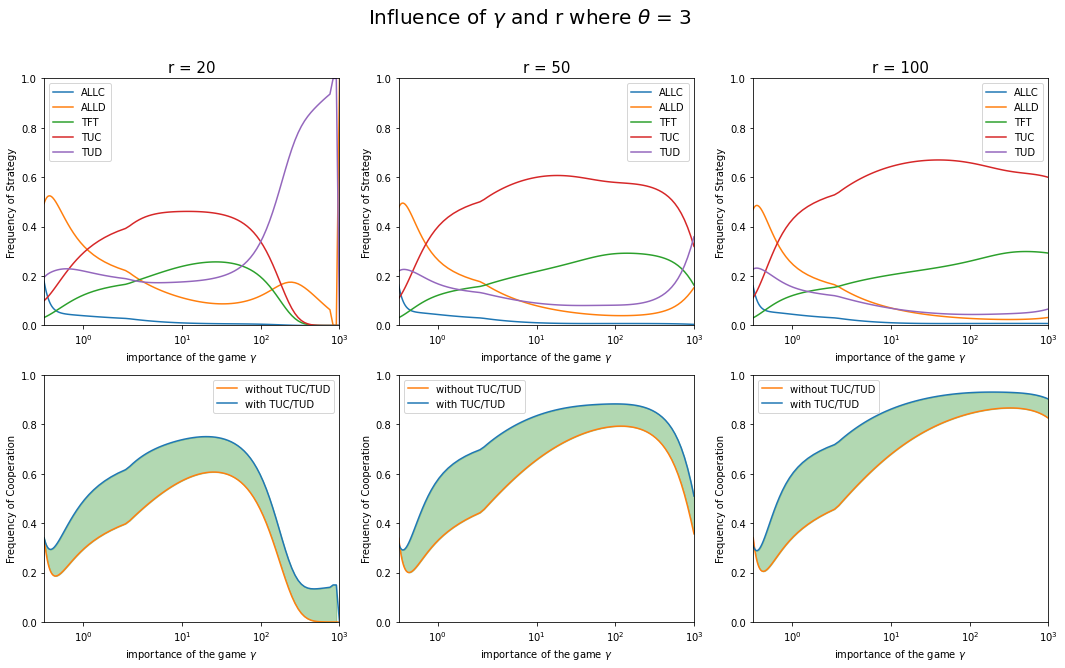

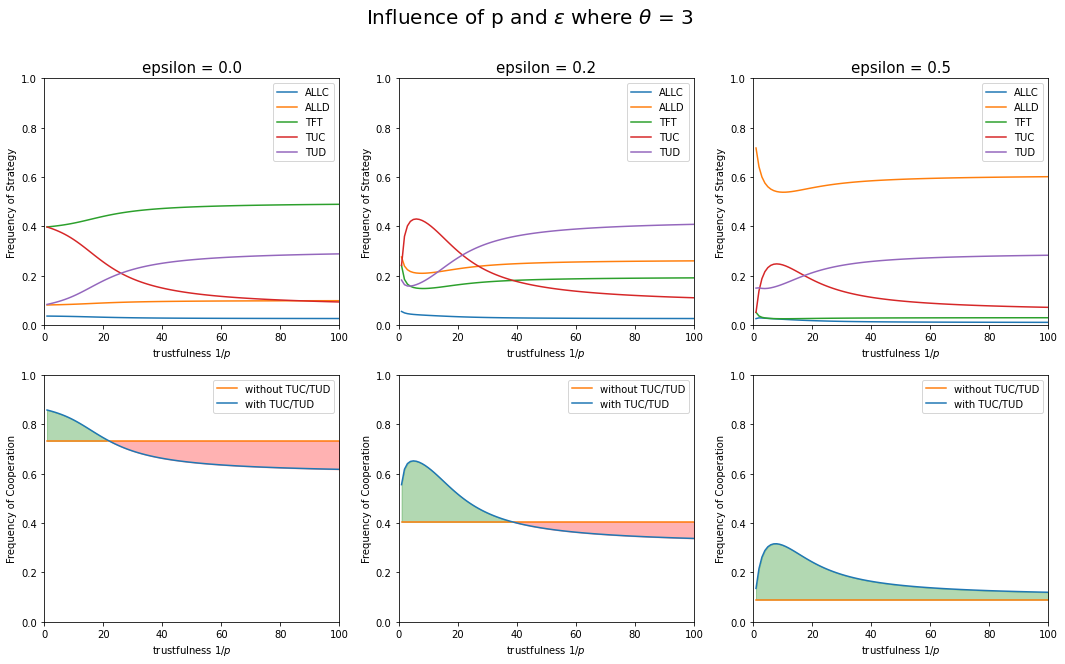

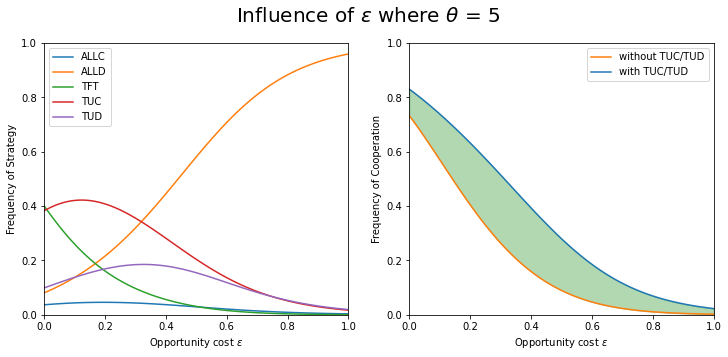

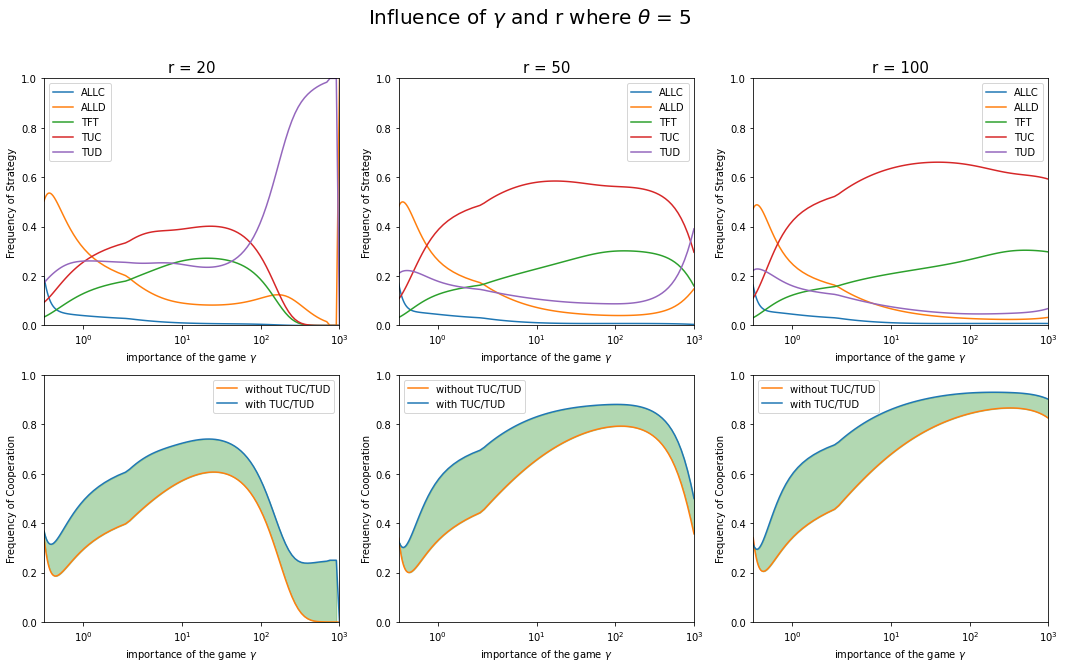

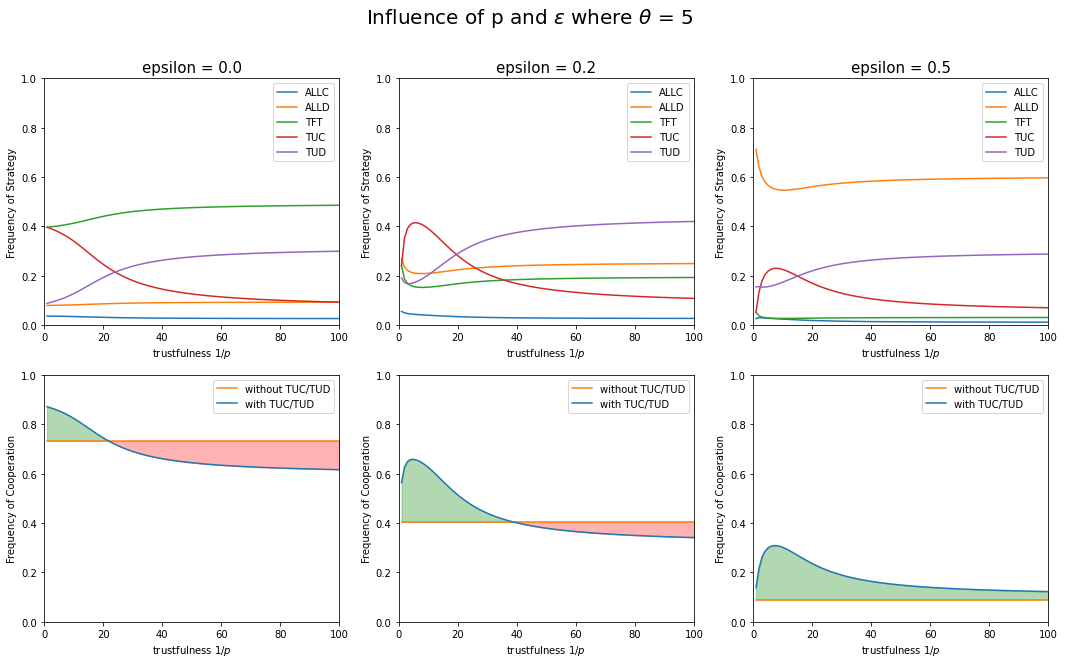

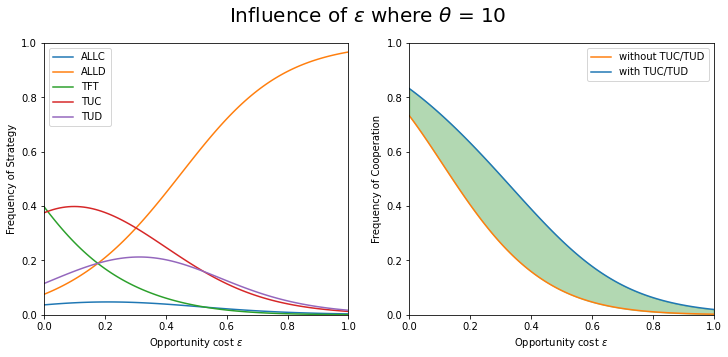

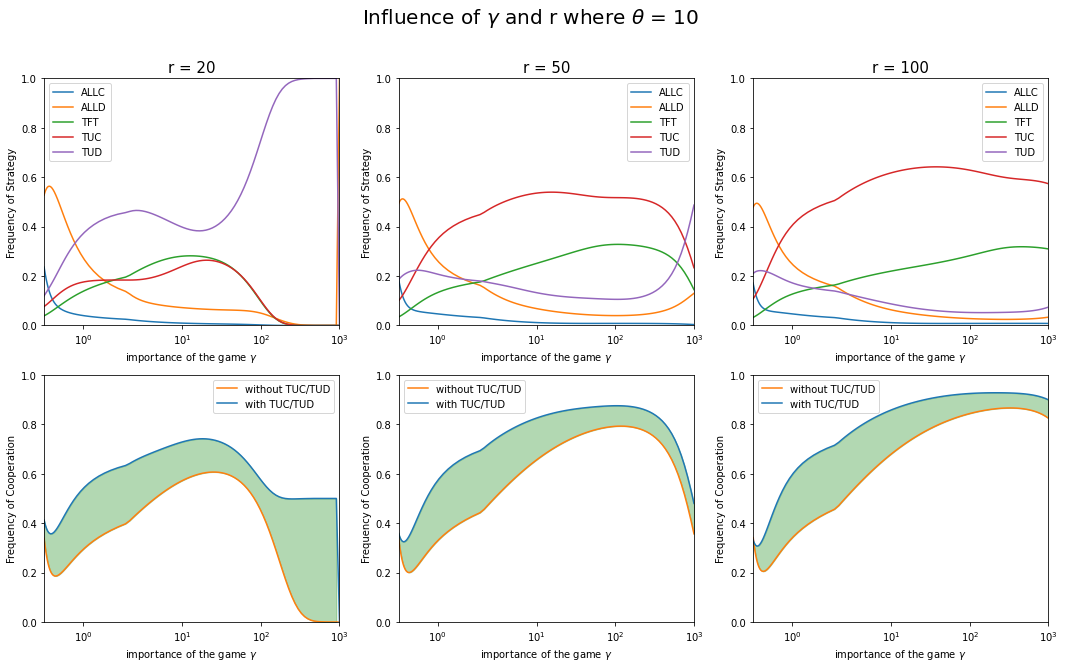

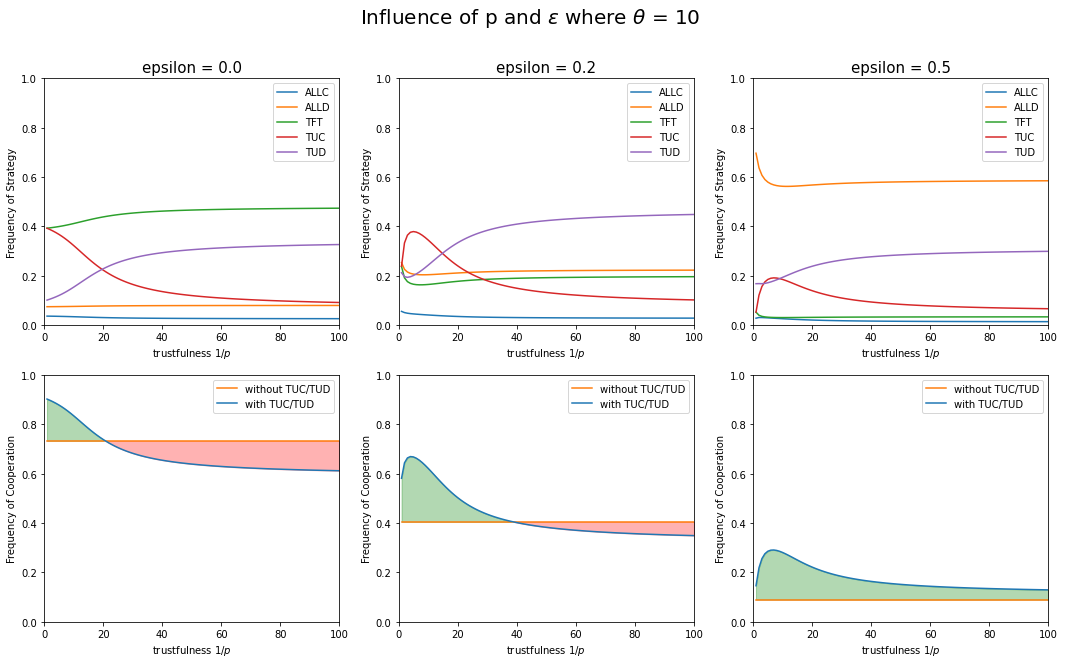

In [32]:
if run_big:
    # test and visualise
    figures_pd = test_and_visualise_theta(R_pd,S_pd,T_pd,P_pd,gamma,r,p,epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,beta,Z,mu,thetas,epsilons,gammas,rs,ps,epsilons_ps,"prisoner")

In [33]:
if run_big:
    # close the figures
    for f in figures_pd:
        plt.close(f)

#### Snowdrift game

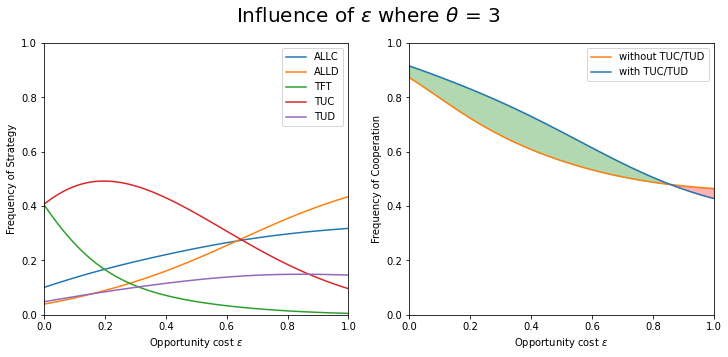

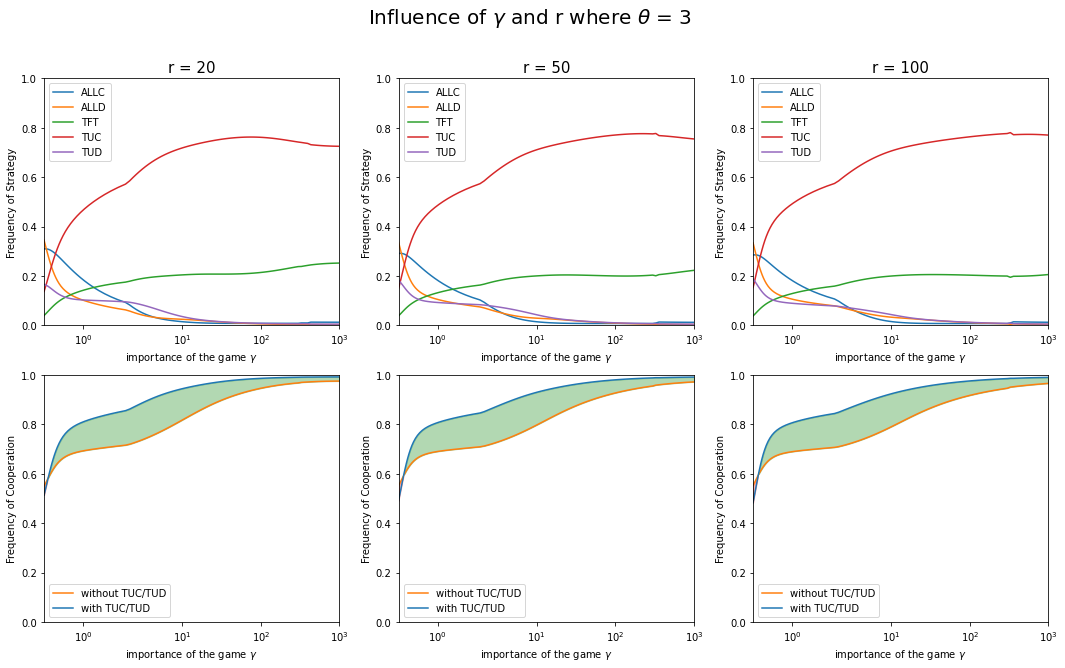

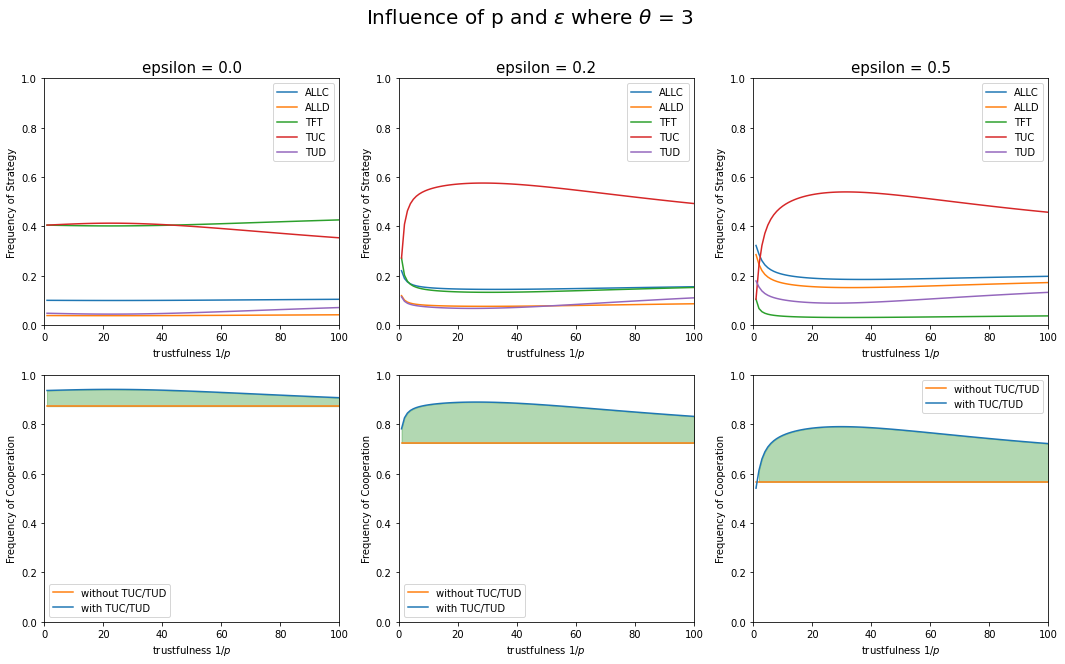

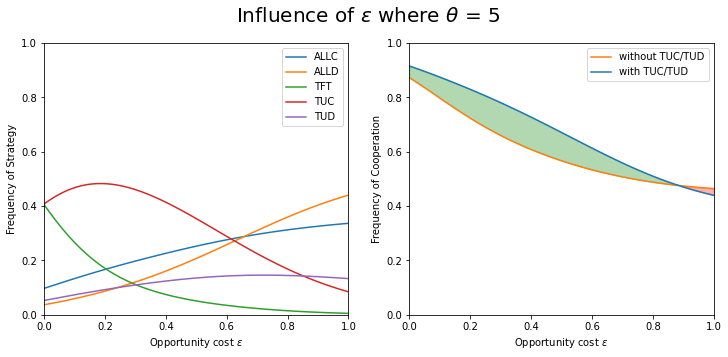

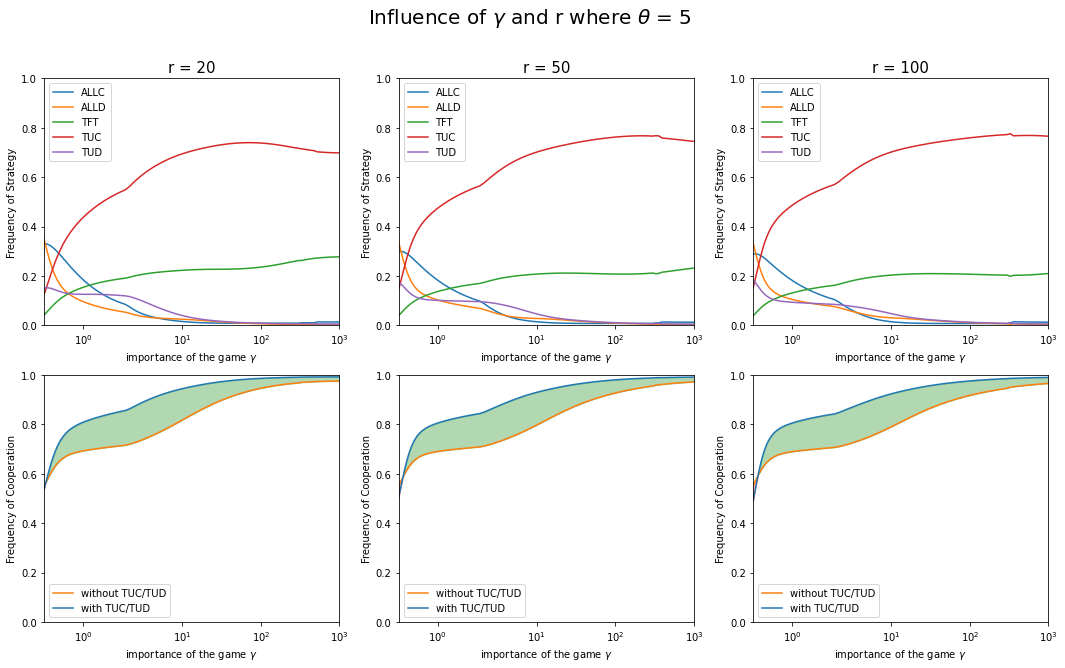

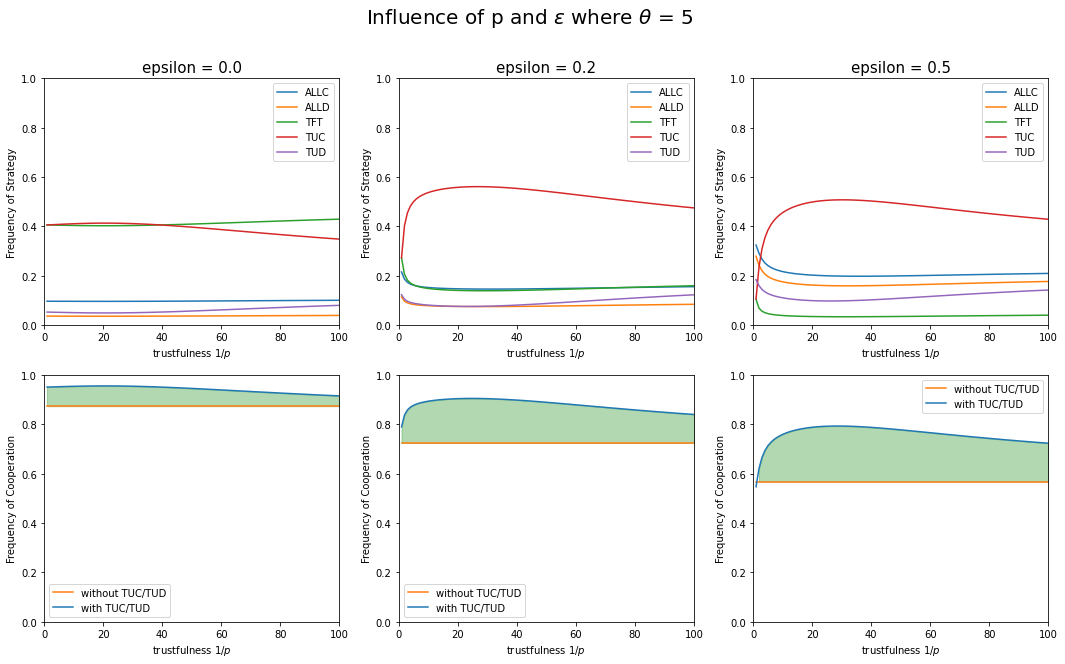

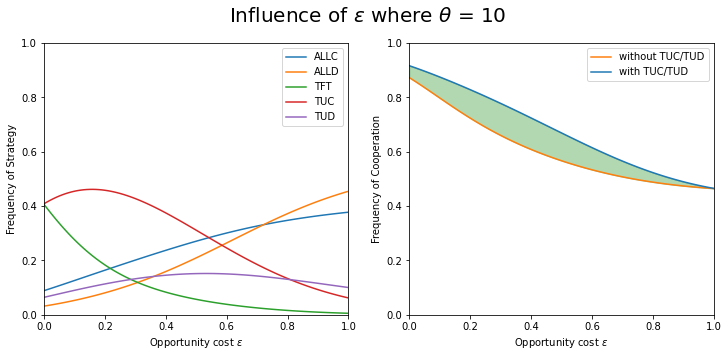

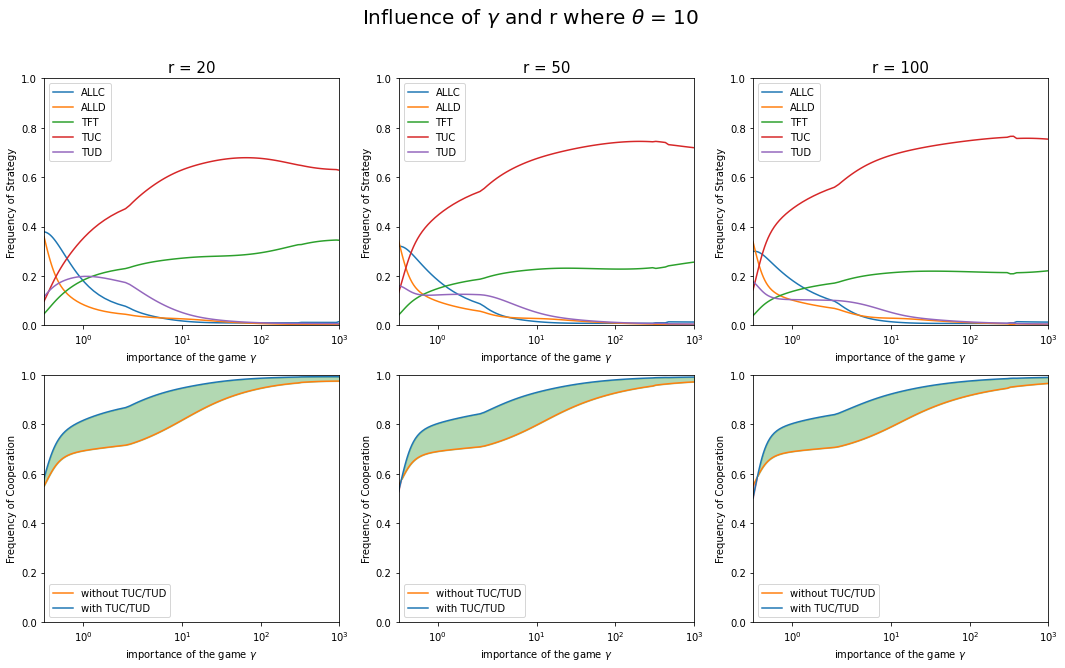

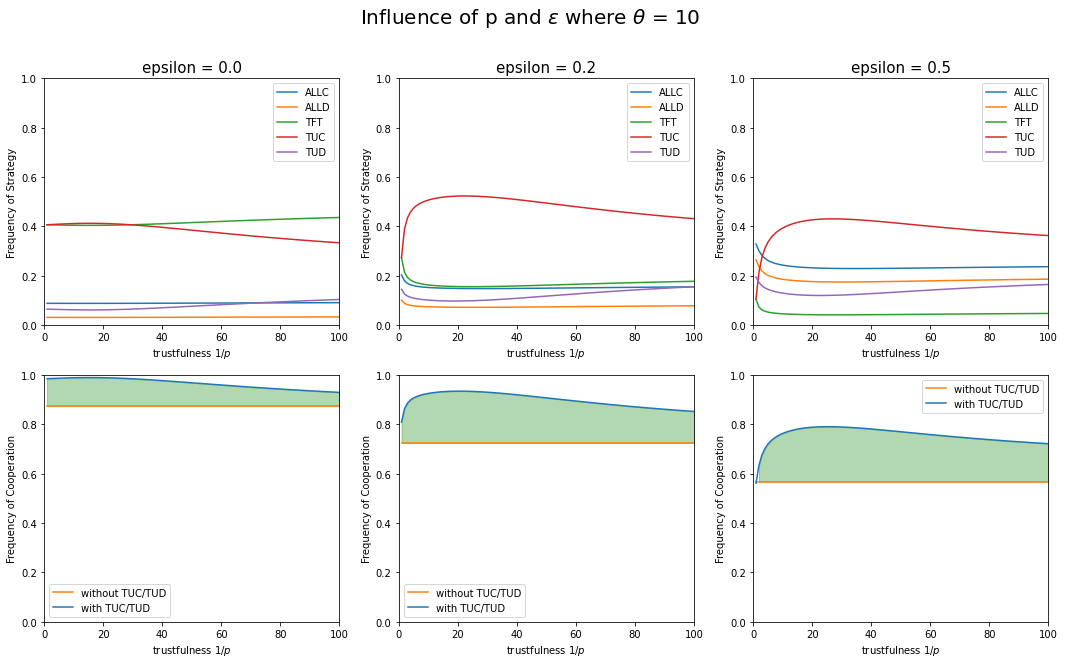

In [34]:
if run_big:
    # test and visualise
    figures = test_and_visualise_theta(R_sd,S_sd,T_sd,P_sd,gamma,r,p,epsilon,nb_strategies_with,strategies,colors_strat,nb_strategies_without,colors_trust,beta,Z,mu,thetas,epsilons,gammas,rs,ps,epsilons_ps,"snowdrift")

In [35]:
if run_big:
    # close the figures
    for f in figures:
        plt.close(f)